# Линейные модели, функции потерь, градиенты, SGD
(c) Deniz Yuret, 2019
* Задачи: определить, обучить и визуализировать простую модель; понимать градиенты и SGD; научиться использовать графический процессор.

* Новые функции: 
[mnistdata](https://github.com/denizyuret/Knet.jl/blob/master/data/mnist.jl),
[accuracy](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.accuracy), 
[zeroone](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.zeroone), 
[nll](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.nll), 
[Param, @diff, value, params, grad](http://denizyuret.github.io/Knet.jl/latest/reference/#AutoGrad),
[sgd](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.sgd),
[progress, progress!](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.progress), 
[gpu](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.gpu), 
[KnetArray](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.KnetArray), 
[load](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.load), 
[save](http://denizyuret.github.io/Knet.jl/latest/reference/#Knet.save)


<img src="https://www.oreilly.com/library/view/tensorflow-for-deep/9781491980446/assets/tfdl_0401.png" alt="A linear model" width=300/> ([image source](https://www.oreilly.com/library/view/tensorflow-for-deep/9781491980446/ch04.html))

В Knet модель машинного обучения определяется с использованием простого кода Julia. Типичная модель состоит из функции **прогнозирования** и **потери**. Функция прогнозирования принимает некоторые входные данные и возвращает прогноз модели для этих входных данных. Функция потерь измеряет, насколько плох прогноз по отношению к некоторому желаемому результату.
Мы обучаем модель, корректируя ее параметры, чтобы уменьшить потери.

В этом разделе мы реализуем простую линейную модель для классификации цифр MNIST. Функция прогнозирования будет возвращать 10 баллов для каждой из возможных меток 0..9 в виде линейной комбинации значений пикселей.
Функция потерь преобразует эти оценки в нормированные вероятности и возвращает среднюю вероятность логов правильных ответов. Минимизация этой потери должна максимизировать оценки, назначенные для правильных ответов по модели. Мы будем использовать градиент потерь по каждому параметру,
что говорит нам направление наибольшего увеличения потерь. Мы будем совершенствовать модель, перемещая параметры в противоположном направлении (используя графический процессор, если он доступен). Мы будем визуализировать вес модели и производительность с течением времени. Окончательная точность около 92% близка к пределу того, что мы можем достичь с помощью этого типа модели.
Ну а затем рассмотрим что-нибудь поинтересней линейных моделей.

In [1]:
# Set display width, load packages, import symbols
ENV["COLUMNS"]=72
using Pkg; for p in ("Knet","AutoGrad","Plots","Images","ImageMagick"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Statistics: mean
using Base.Iterators: flatten
import Random # seed!
using Knet: Knet, AutoGrad, dir, Data, Param, @diff, value, params, grad, progress, progress!, gpu, KnetArray, load, save
# Следующее определено для инструкции, даже если они предоставляются в Knet
# using Knet: accuracy, zeroone, nll, sgd

In [2]:
# загрузка тестовых данных
include(Knet.dir("data","mnist.jl"))
dtrn,dtst = mnistdata(xsize=(784,:),xtype=Array)
println.(summary.((dtrn,dtst)));

600-element Data{Tuple{Array{Float32,2},Array{UInt8,1}}}


┌ Info: Loading MNIST...
└ @ Main C:\Users\User\.julia\packages\Knet\T1oum\data\mnist.jl:33


100-element Data{Tuple{Array{Float32,2},Array{UInt8,1}}}


## Определение модели

In [3]:
# В Julia мы определяем новый тип данных, используя `struct`:
struct Linear; w; b; end

# Новая структура поставляется с конструктором по умолчанию:
model = Linear(0.01 * randn(10,784), zeros(10))

# Мы можем определить другие конструкторы с другими входами:
Linear(i::Int,o::Int,scale=0.01) = Linear(scale * randn(o,i), zeros(o))

# А это позволяет определять экземпляры с использованием размеров ввода и вывода:
model = Linear(784,10)

Linear([-0.00621197 -0.000324942 … 0.010628 -0.00861496; 0.00340994 0.0100376 … -0.00403006 0.0112743; … ; -0.0010888 0.00505553 … -0.00607667 -0.00497069; 0.00981951 -0.0106678 … -0.00643246 0.0200267], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

## Прогноз

In [4]:
# Мы превращаем линейные экземпляры в вызываемые объекты для предсказания:
(m::Linear)(x) = m.w * x .+ m.b

In [5]:
x,y = first(dtst) # Первая мини-партия из тестового набора
summary.((x,y))

("784×100 Array{Float32,2}", "100-element Array{UInt8,1}")

In [6]:
Int.(y)' # правильные ответы даются в виде массива целых чисел (помните, что мы используем 10 для 0)

1×100 LinearAlgebra.Adjoint{Int64,Array{Int64,1}}:
 7  2  1  10  4  1  4  9  5  9  …  1  3  6  9  3  1  4  1  7  6  9

In [7]:
ypred = model(x)  # Прогнозы на первую минибатчу: матрица результатов 10x100

10×100 Array{Float64,2}:
 -0.0573706    0.0836898   -0.0993739   …   0.0341014   -0.125484   
 -0.0340025    0.0118058    0.0451012      -0.0658874    0.0276873  
  0.0293171    0.070559    -0.00201588      0.085163     0.0388435  
  0.068166    -0.0514477   -0.0772223      -0.0186688    0.0323772  
 -0.00441849  -0.025335    -0.0217464       0.0426281   -0.000801449
  0.102021     0.0436141    0.0867583   …   0.0987738    0.0433309  
 -0.0436877    0.0792506   -0.00330623     -0.0109909   -0.113095   
  0.167162     0.00859507  -0.0264033       0.0839035    0.17578    
  0.0891127   -0.0194897    0.0988181      -0.00689439   0.151461   
 -0.0394966   -0.0226349   -0.129688        0.0667691    0.117331   

In [7]:
# Мы можем рассчитать точность нашей модели для первой мини-партии
accuracy(model,x,y) = mean(y' .== map(i->i[1], findmax(Array(model(x)),dims=1)[2]))
accuracy(model,x,y)

0.02

In [8]:
# Мы можем рассчитать точность нашей модели для всего тестового набора
accuracy(model,data) = mean(accuracy(model,x,y) for (x,y) in data)
accuracy(model,dtst)

0.07740000000000001

In [10]:
# ZeroOne - потери (или ошибка) определяется как 1 отнять точность
zeroone(x...) = 1 - accuracy(x...)
zeroone(model,dtst)

0.9017000000000001

## Функция потерь

In [9]:
# Для классификации мы используем отрицательную логарифмическую потерю правдоподобия
# (она же перекрестная энтропия, потеря softmax, NLL)
# Это средняя вероятность -log, назначенная для правильных ответов по модели
function nll(scores, y)
    expscores = exp.(scores)
    probabilities = expscores ./ sum(expscores, dims=1)
    answerprobs = (probabilities[y[i],i] for i in 1:length(y))
    mean(-log.(answerprobs))
end

nll (generic function with 1 method)

In [10]:
# model(x) возвращает прогноз, пусть model(x,y) будет возвращать ошибку
(m::Linear)(x, y) = nll(m(x), y)
model(x,y)

2.3434559237471633

In [11]:
# Мы также можем использовать реализацию Knet nll для эффективности
(m::Linear)(x, y) = Knet.nll(m(x), y)
model(x,y)

2.343455923747163

In [12]:
# Если входными данными является набор данных, вычислите средние потери:
(m::Linear)(data::Data) = mean(m(x,y) for (x,y) in data)

In [13]:
# Вот среднее отрицательное логарифмическое правдоподобие для каждого теста
model(dtst)

2.327400148902523

**Бонус вопрос:** Что особенного в величине потерь 2.3?

## Расчет градиента с помощью AutoGrad

In [14]:
@doc AutoGrad

Usage:

```
x = Param([1,2,3])          # user declares parameters with `Param`
x => P([1,2,3])             # `Param` is just a struct wrapping a value
value(x) => [1,2,3]         # `value` returns the thing wrapped
sum(x .* x) => 14           # Params act like regular values
y = @diff sum(x .* x)       # Except when we differentiate using `@diff`
y => T(14)                  # you get another struct
value(y) => 14              # which carries the same result
params(y) => [x]            # and the Params that it depends on 
grad(y,x) => [2,4,6]        # and the gradients for all Params
```

`Param(x)` returns a struct that acts like `x` but marks it as a parameter you want to compute gradients with respect to.

`@diff expr` evaluates an expression and returns a struct that contains the result (which should be a scalar) and gradient information.

`grad(y, x)` returns the gradient of `y` (output by @diff) with respect to any parameter `x::Param`, or  `nothing` if the gradient is 0.

`value(x)` returns the value associated with `x` if `x` is a `Param` or the output of `@diff`, otherwise returns `x`.

`params(x)` returns an iterator of Params found by a recursive search of object `x`.

Alternative usage:

```
x = [1 2 3]
f(x) = sum(x .* x)
f(x) => 14
grad(f)(x) => [2 4 6]
gradloss(f)(x) => ([2 4 6], 14)
```

Given a scalar valued function `f`, `grad(f,argnum=1)` returns another function `g` which takes the same inputs as `f` and returns the gradient of the output with respect to the argnum'th argument. `gradloss` is similar except the resulting function also returns f's output.


In [17]:
# Переопределите конструктор, чтобы использовать параметры Param, чтобы мы могли вычислять градиенты
Linear(i::Int,o::Int,scale=0.01) = 
    Linear(Param(scale * randn(o,i)), Param(zeros(o)))

Linear

In [18]:
# Установите случайное семя для воспроизводимости результата
Random.seed!(9);

In [19]:
# Используйте больший масштаб, чтобы получить большие начальные потери
model = Linear(784,10,1.0)

Linear(P(Array{Float64,2}(10,784)), P(Array{Float64,1}(10)))

In [20]:
# Мы все еще можем делать прогнозы и рассчитывать потери:
model(x,y)

19.10423456298375

In [21]:
# И мы можем сделать то же самое вычисление потерь также вычисляя градиенты
J = @diff model(x,y)

T(19.10423456298375)

In [22]:
# Чтобы получить фактическое значение убытка от J:
value(J)

19.10423456298375

In [15]:
# params(J) возвращает итератор по параметрам J (т.е. model.b, model.w):
params(J) |> collect

UndefVarError: UndefVarError: J not defined

In [24]:
# Чтобы получить градиент параметра от J:
∇w = grad(J,model.w)

10×784 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0

In [25]:
# Обратите внимание, что каждый градиент имеет тот же размер и форму, что и соответствующий параметр:
@show ∇b = grad(J,model.b);

∇b = grad(J, model.b) = [-0.139954, -0.064541, -0.109522, -0.1275, -0.059184, -0.0980703, -0.102617, 0.0133898, -0.104578, 0.792576]


## Проверка градиента с помощью численного приближения

Каков смысл ∇b?

∇b[10] = 0,79 означает, что если я увеличу b[10] на ϵ, потери увеличатся на 0,79ϵ

In [26]:
# Потеря для первой мини-партии с исходными параметрами
@show value(model.b)
model(x,y)

value(model.b) = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


19.10423456298375

In [27]:
# Чтобы численно проверить градиент, давайте увеличим последнюю запись b на +0.1.
model.b[10] = 0.1

0.1

In [28]:
# Мы видим, что потери движутся на ≈ + 0.79 * 0.1, как и ожидалось.
@show value(model.b)
model(x,y)

value(model.b) = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1]


19.183620170313954

In [29]:
# Сбросить изменения.
model.b[10] = 0

0

## Проверка градиента с использованием ручной реализации

In [30]:
# Без AutoGrad нам пришлось бы определять градиенты вручную:
function nllgrad(model,x,y)
    scores = model(x)
    expscores = exp.(scores)
    probabilities = expscores ./ sum(expscores, dims=1)
    for i in 1:length(y); probabilities[y[i],i] -= 1; end
    dJds = probabilities / length(y)
    dJdw = dJds * x'
    dJdb = vec(sum(dJds,dims=2))
    dJdw,dJdb
end;

In [31]:
∇w2,∇b2 = nllgrad(model,x,y)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-0.139954, -0.064541, -0.109522, -0.1275, -0.059184, -0.0980703, -0.102617, 0.0133898, -0.104578, 0.792576])

In [32]:
∇w2 ≈ ∇w

true

In [33]:
∇b2 ≈ ∇b

true

## Тренировка со стохастическим градиентным спуском (SGD)

In [34]:
# Вот небольшой апдэйт для SGD:
function sgdupdate!(func, args; lr=0.1)
    fval = @diff func(args...)
    for param in params(fval)
        ∇param = grad(fval, param)
        param .-= lr * ∇param
    end
    return value(fval)
end

sgdupdate! (generic function with 1 method)

Мы определяем SGD для набора данных как итератор, чтобы:
1. отслеживать и сообщать о потере обучения
2. мочь сделать снимки модели во время тренировки
3. мочь приостановить / прекратить обучение, когда это необходимо

In [35]:
sgd(func, data; lr=0.1) = 
    (sgdupdate!(func, args; lr=lr) for args in data)

sgd (generic function with 1 method)

In [36]:
# Давайте потренируем модель для 10 эпох, чтобы сравнить скорость обучения на CPU против GPU.
# progress!(itr) displays a progress bar when wrapped around an iterator like this:
# 2.94e-01  100.00%┣████████████████████┫ 6000/6000 [00:10/00:10, 592.96/s] 2.31->0.28
model = Linear(784,10)
@show model(dtst)
progress!(sgd(model, repeat(dtrn,10)))
@show model(dtst);

model(dtst) = 2.313187215962106
3.03e-01  100.00%┣███████████████████┫ 6000/6000 [00:10/00:10, 598.92i/s]
model(dtst) = 0.2806535683801265


## Используем GPU

In [37]:
# Обучение будет проходить намного быстрее на GPU:
# 2.94e-01  100.00%┣███████████████████┫ 6000/6000 [00:02/00:02, 2653.45/s]  2.31->0.28
# Для работы на GPU все, что нам нужно сделать, это преобразовать массивы в KnetArrays:
if gpu() >= 0  # gpu() вернет id устройства >= 0 если есть GPU, иначе -1 
    atype = KnetArray{Float32}  # KnetArrays хранятся и работают в графическом процессоре
    dtrn,dtst = mnistdata(xsize=(784,:),xtype=atype)
    Linear(i::Int,o::Int,scale=0.01) = 
        Linear(Param(atype(scale * randn(o,i))), 
               Param(atype(zeros(o))))

    model = Linear(784,10)
    @show model(dtst)
    progress!(sgd(model,repeat(dtrn,10)))
    @show model(dtst)
end;

model(dtst) = 2.3035536f0
3.03e-01  100.00%┣██████████████████┫ 6000/6000 [00:04/00:04, 1654.96i/s]
model(dtst) = 0.28049186f0



## Запись прогресса

In [16]:
function trainresults(file, model)
    if (print("Тринируем с нуля? (~77s) "); readline()[1]=='y')
        # Это займет каждый n-й элемент итератора:
        takeevery(n,itr) = (x for (i,x) in enumerate(itr) if i % n == 1)
        # Мы будем использовать его для создания снимка модели и результатов каждой эпохи (т.е. 600 итераций)
        lin = ((deepcopy(model),model(dtrn),model(dtst),zeroone(model,dtrn),zeroone(model,dtst))
        # (Progress отображает столбики и возвращает итератор, Progress! Ничего не возвращает)
               for x in takeevery(length(dtrn), progress(sgd(model,repeat(dtrn,100)))))
        # Сохранить его как массив 5x100
        lin = reshape(collect(flatten(lin)),(5,:))
        # Knet.save и Knet.load может использоваться для хранения моделей в файлах
        Knet.save(file,"results",lin)
    else
        isfile(file) || download("http://people.csail.mit.edu/deniz/models/tutorial/$file", file)
        lin = Knet.load(file,"results")    
    end
    return lin
end

trainresults (generic function with 1 method)

In [17]:
# 2.43e-01  100.00%┣████████████████▉┫ 60000/60000 [00:44/00:44, 1349.13/s]
lin = trainresults("lin113.jld2",Linear(784,10));

Тринируем с нуля? (~77s) stdin> n


## Результаты обучения линейной модели

In [40]:
using Plots; default(fmt = :png)

In [18]:
# Если потери далеки от нуля - недоучили
# Переобучение - тестовые потери выше тренировочных
plot([lin[2,:], lin[3,:]],ylim=(.0,.4),labels=[:trnloss :tstloss],xlabel="Epochs",ylabel="Loss")

UndefVarError: UndefVarError: plot not defined

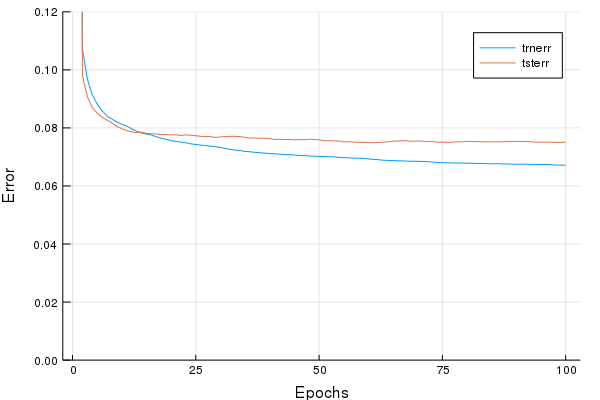

In [42]:
# это график ошибок, мы получаем около 7,5% ошибок при тестировании, то есть точность 92,5%
plot([lin[4,:], lin[5,:]],ylim=(.0,.12),labels=[:trnerr :tsterr],xlabel="Epochs",ylabel="Error")

## Визуализация обученных весов

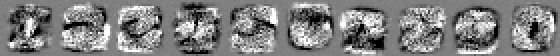

"Epoch 99"

In [43]:
# Давайте визуализируем эволюцию весовой матрицы в виде изображений ниже
# Каждый ряд превращается в изображение размером 28x28 с положительными весами - светлыми и отрицательными темными.
using Images, ImageMagick
for t in 10 .^ range(0,stop=log10(size(lin,2)),length=20) #logspace(0,2,20)
    i = ceil(Int,t)
    f = lin[1,i]
    w1 = reshape(Array(value(f.w))', (28,28,1,10))
    w2 = clamp.(w1.+0.5,0,1)
    IJulia.clear_output(true)
    display(hcat([mnistview(w2,i) for i=1:10]...))
    display("Epoch $(i-1)")
    sleep(1) # (0.96^i)
end